# Tutorial: Simulated Ground Telescopes

This tutorial focuses on simulating data from a ground-based telescope.  We first create a fake telescope with a synthetic focalplane located in Chile.  Then we create a synthetic observing schedule and use that to scan the sky.  Later notebooks make use of helper functions that create generic focalplanes, but in this example we use low-level functions to customize things a bit more. 

In [1]:
# TOAST interactive startup
import toast.interactive
%load_ext toast.interactive

In [2]:
%toast -p 1 -a

Using 1 processes with 1 threads each.


1

In [3]:
# Built-in modules
import sys
import os
import re
import datetime

# External modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Row, QTable

# TOAST
import toast
from toast.instrument_sim import plot_focalplane
from toast.tests import helpers
from toast.observation import default_values as defaults

# Display inline plots
%matplotlib inline

In [4]:
# MPI communicator
world, procs, rank = toast.mpi.get_world()
comm = helpers.create_comm(world, single_group=True)

In [5]:
# Output directory
out_dir = helpers.create_outdir(world, topdir="out_sim_ground")

## Helper Functions

Here are a few functions we will use later in the notebook.

In [6]:
def plot_dets(obs, d_start=0, d_end=None, s_start=0, s_end=None, view=None, signal=defaults.det_data):
    """Plot some detectors in an observation.
    
    Args:
        obs (Observation):  The observation
        d_start (int):  The starting local detector index to plot.
        d_end (int): The local detector index limit to plot.
        s_start (int):  The starting sample index to plot.
        s_end (int):  The sample index limit to plot
        view (str):  The optional intervals to overplot.
        signal (str):  The detdata name to plot.
    """
    slc = slice(s_start, s_end, 1)

    fig = plt.figure(dpi=100, figsize=(18, 12))
    ax = fig.add_subplot(2, 1, 1, aspect="auto")
    plt.gca().set_prop_cycle(None)
    for idet, det in enumerate(obs.select_local_detectors(flagmask=defaults.det_mask_nonscience)):
        if idet < d_start:
            continue
        if d_end is not None and idet >= d_end:
            continue
        ax.plot(
            obs.shared[defaults.times].data[slc], 
            obs.detdata[signal][det, slc], 
            '-',
            label=det,
        )
    ax.legend(loc="best")
    
    ax = fig.add_subplot(2, 1, 2, aspect="auto")
    
    if view is not None:
        inview = np.zeros_like(obs.shared[defaults.shared_flags].data[slc])
        begin = [x.first for x in obs.intervals[view]]
        end = [x.last+1 for x in obs.intervals[view]]
        for b, e in zip(begin, end):
            inview[b:e] = 1
        ax.plot(
            obs.shared[defaults.times].data[slc], 
            inview, 
            '-',
            color="red",
            label=f"View {view}",
        )
    ax.plot(
        obs.shared[defaults.times].data[slc], 
        obs.shared[defaults.shared_flags].data[slc], 
        '-',
        color="black",
        label="Shared Flags",
    )
    
    plt.gca().set_prop_cycle(None)
    for idet, det in enumerate(obs.select_local_detectors(flagmask=defaults.det_mask_nonscience)):
        if idet < d_start:
            continue
        if d_end is not None and idet >= d_end:
            continue
        ax.plot(
            obs.shared[defaults.times].data[slc], 
            obs.detdata[defaults.det_flags][det, slc], 
            '-',
            label=det,
        )
    ax.legend(loc="best")    
    plt.show()
    plt.close()

In [7]:
def plot_scanning(obs, s_start=0, s_end=None):
    slc = slice(s_start, s_end, 1)
    times = obs.shared[defaults.times].data[slc]
    az = obs.shared[defaults.azimuth].data[slc]
    el = obs.shared[defaults.elevation].data[slc]
    
    fig = plt.figure(dpi=100, figsize=(18, 12))
    ax = fig.add_subplot(2, 1, 1, aspect="auto")
    ax.plot(times, az, label="Azimuth")
    ax.set_xlabel("Posix Timestamps")
    ax.set_ylabel("Azimuth")
    ax = fig.add_subplot(2, 1, 2, aspect="auto")
    ax.plot(times, el, label="Elevation")
    ax.set_xlabel("Posix Timestamps")
    ax.set_ylabel("Elevation")
    plt.show()
    plt.close()

# Fake Telescope

We create just a small number of detectors here since we are running this notebook serially.  If you use more processes you can increase the number of detectors on the focalplane.  First create a `Site` for telescope:

In [8]:
site = toast.instrument.GroundSite("atacama", "-22:57:30", "-67:47:10", 5200.0 * u.meter)

Now we will create a focalplane consisting of three rhombus wafers packed into a hexagon.

In [9]:
focalplane = toast.instrument_sim.fake_rhombihex_focalplane(
    n_pix_rhombus=9,
    width=5.0 * u.degree,
    gap=0 * u.radian,
    sample_rate=10.0 * u.Hz,
    epsilon=0.0,
    fwhm=30.0 * u.arcmin,
    bandcenter=150 * u.GHz,
    bandwidth=20 * u.GHz,
    psd_net=0.1 * u.K * np.sqrt(1 * u.second),
    psd_fmin=1.0e-5 * u.Hz,
    psd_alpha=1.0,
    psd_fknee=0.05 * u.Hz,
    fwhm_sigma=0.0 * u.arcmin,
    bandcenter_sigma=0 * u.GHz,
    bandwidth_sigma=0 * u.GHz,
    random_seed=123456,
)
fov = focalplane.field_of_view

In [10]:
# Look at the table of detector properties
focalplane.detector_data

name,quat,pol_leakage,psi_pol,gamma,fwhm,psd_fmin,psd_fknee,psd_alpha,psd_net,bandcenter,bandwidth,pixel,uid,pol_angle,pol_efficiency
,,,rad,rad,arcmin,Hz,Hz,,K s(1/2),GHz,GHz,,,rad,
str8,float64[4],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,int64,float64,float64
D00A-150,0.014592296980275381 .. 0.793292180607777,0.0,0.0,-4.451240197393401,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D00,13695585,1.3083463341878865,1.0
D00B-150,-0.004515706339666553 .. 0.1308059735750587,0.0,1.5707963267948966,-2.8804438705985045,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D00,3323871520,2.879142660982783,1.0
D01A-150,0.010420563113780706 .. 0.7933620976611746,0.0,0.0,1.8322705201745069,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D01,2124332096,1.308671744576208,1.0
D01B-150,-0.0003386153131637662 .. 0.13067253758339858,0.0,1.5707963267948966,-2.8801184602101833,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D01,3717416763,2.8794680713711043,1.0
D02A-150,0.024334062012027396 .. 0.9656767338024275,0.0,0.0,1.046872295709988,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D02,1959492484,0.5232735201116894,1.0
D02B-150,0.014902345691018296 .. 0.4999900761255529,0.0,1.5707963267948966,-3.6655166846747007,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D02,4178092391,2.0940698469065864,1.0
D03A-150,0.006246504216135268 .. 0.7933375940133531,0.0,0.0,1.8325957145940457,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D03,3533511285,1.3089969389957468,1.0
D03B-150,0.0038354435844816775 .. 0.1305236015689644,0.0,1.5707963267948966,-2.879793265790644,30.0,1e-05,0.05,1.0,0.1,150.0,20.0,D03,1849438357,2.8797932657906435,1.0


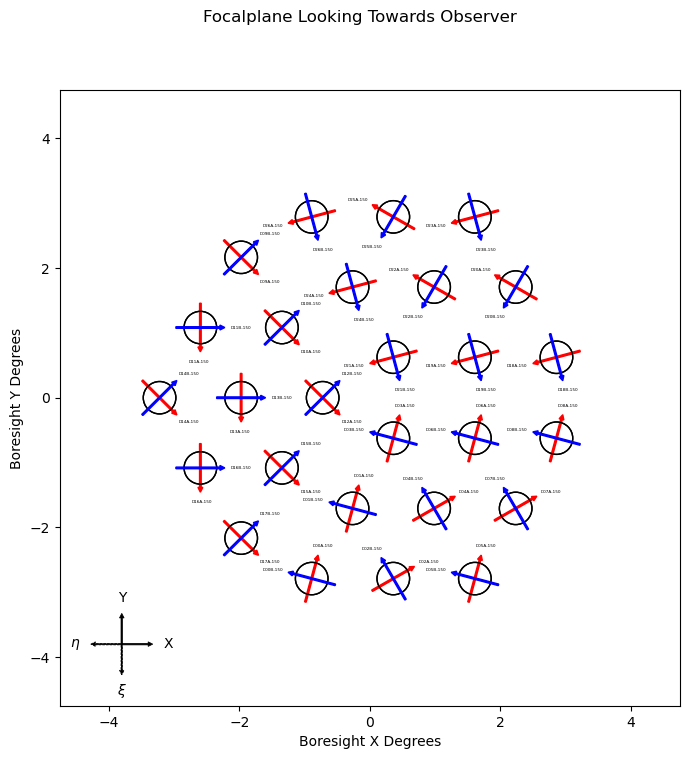

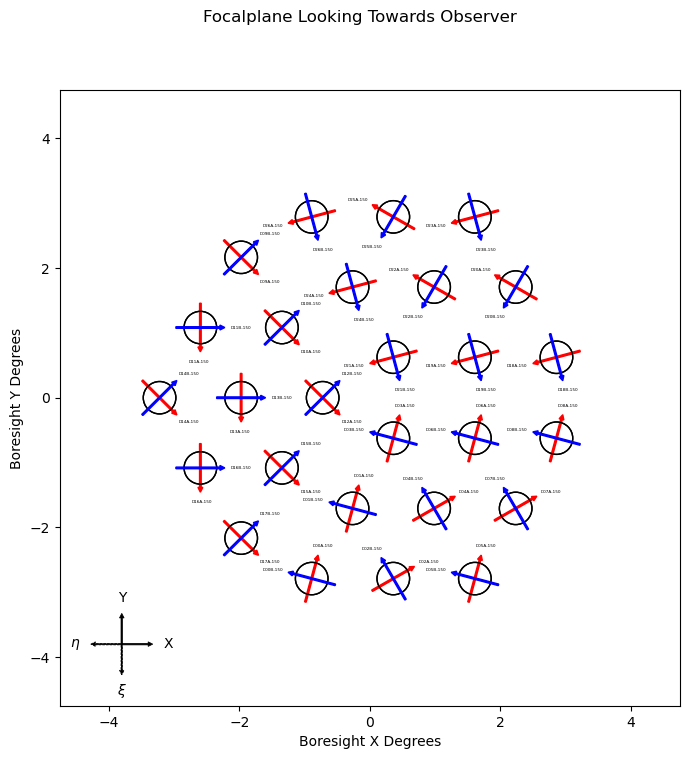

In [11]:
# Make a plot of this focalplane layout.
detpolcol = {
    x: "red" if re.match(r".*A-.*", x) is not None else "blue" for x in focalplane.detectors
}

plot_focalplane(
    focalplane=focalplane,
    width=1.2 * fov,
    height=1.2 * fov,
    show_labels=True,
    pol_color=detpolcol
)

## Atmospheric Monitoring

In order to provide a channel to monitor the atmospheric water content, we add a single detector at the boresight whose bandpass is centered on the water line at 183GHz.  We make a copy of the previous detector table and construct a new focalplane.

In [12]:
det_props = QTable(focalplane.detector_data)

In [13]:
# Copy the last row into a dictionary
atm_det = {x: det_props[-1][x] for x in det_props.colnames}
print(atm_det)

{'name': np.str_('D26B-150'), 'quat': array([ 0.0145923 ,  0.02097847,  0.6083046 , -0.79329218]), 'pol_leakage': np.float64(0.0), 'psi_pol': <Quantity 1.57079633 rad>, 'gamma': <Quantity 1.30964754 rad>, 'fwhm': <Quantity 30. arcmin>, 'psd_fmin': <Quantity 1.e-05 Hz>, 'psd_fknee': <Quantity 0.05 Hz>, 'psd_alpha': np.float64(1.0), 'psd_net': <Quantity 0.1 K s(1/2)>, 'bandcenter': <Quantity 150. GHz>, 'bandwidth': <Quantity 20. GHz>, 'pixel': np.str_('D26'), 'uid': np.int64(1728207812), 'pol_angle': <Quantity 1.83324632 rad>, 'pol_efficiency': np.float64(1.0)}


In [14]:
# Modify the atmosphere detector properties
atm_det["name"] = "ATM0"
atm_det["quat"] = np.array([0.0, 0.0, 0.0, 1.0])
atm_det["bandcenter"] = 183.0 * u.GHz
atm_det["bandwidth"] = 20.0 * u.GHz
det_props.add_row(atm_det)

In [15]:
# Build a new focalplane with the updated table
full_fp = toast.instrument.Focalplane(
    detector_data=det_props,
    sample_rate=focalplane.sample_rate,
)

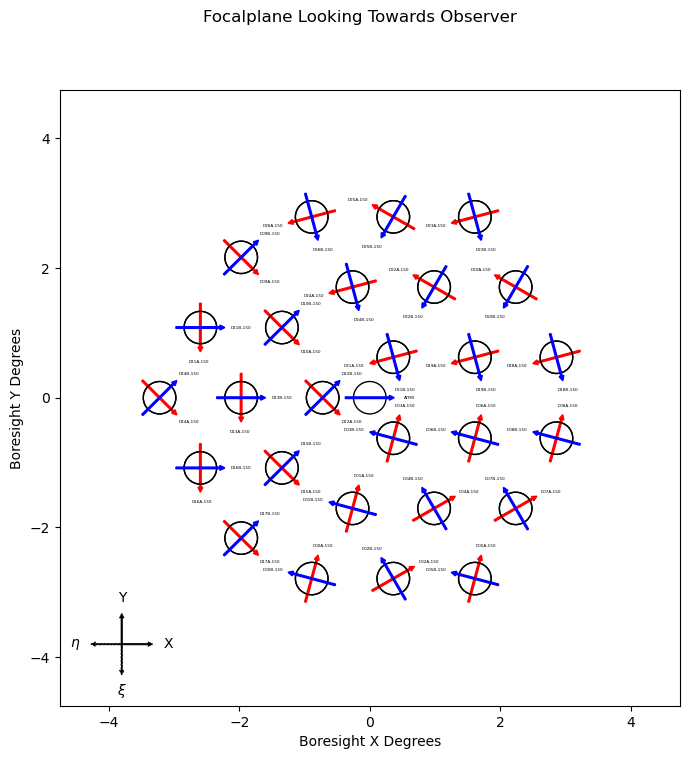

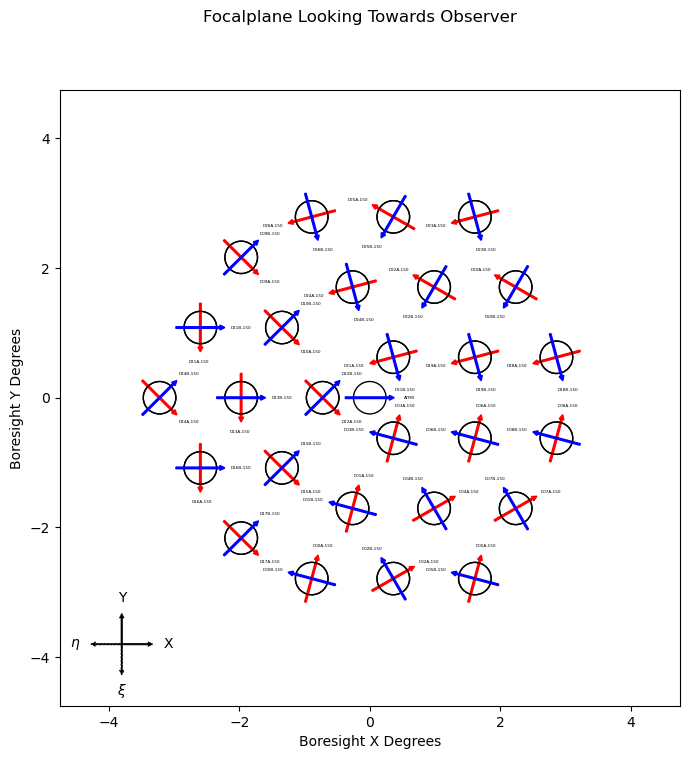

In [16]:
detpolcol = {
    x: "red" if re.match(r".*A-.*", x) is not None else "blue" for x in full_fp.detectors
}

plot_focalplane(
    focalplane=full_fp,
    width=1.2 * fov,
    height=1.2 * fov,
    show_labels=True,
    pol_color=detpolcol
)

We can check the top-hat bandpasses in this Focalplane.  We just look at the first normal detector and the last detector which is the atmosphere monitor.

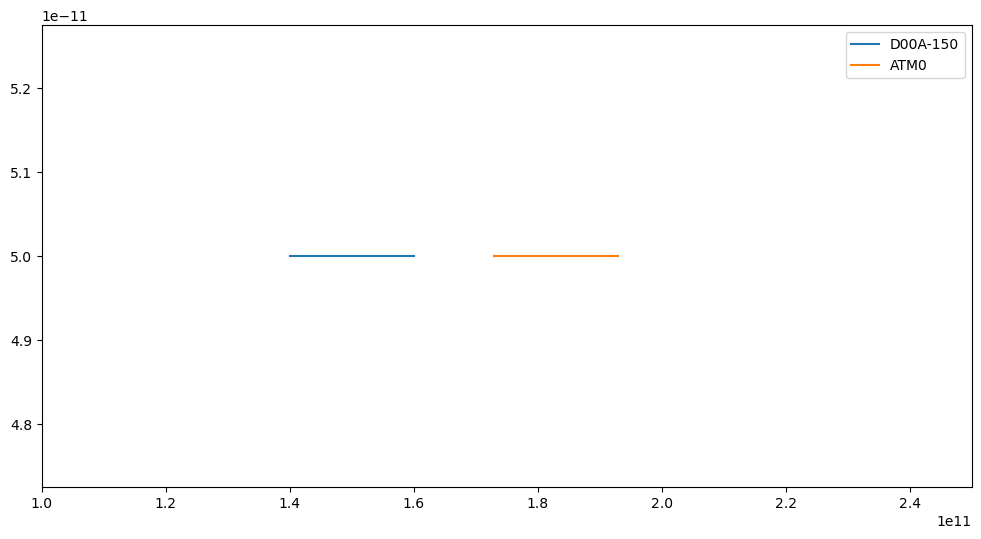

In [17]:
fig = plt.figure(dpi=100, figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
for det in [full_fp.detectors[0], full_fp.detectors[-1]]:
    freq = full_fp.bandpass.freqs(det)
    bpass = full_fp.bandpass.bandpass(det)
    ax.plot(
        freq, 
        bpass, 
        '-',
        label=det,
    )
ax.set_xlim(100e9, 250e9)
ax.legend(loc="best")
plt.show()
plt.close()

Finally we build our telescope with this updated focalplane and Site

In [18]:
telescope = toast.instrument.Telescope("telescope", focalplane=full_fp, site=site)

# Simulated Observing Schedule

Now that we have a telescope, we create an observing schedule.

In [19]:
schedule = None

if rank == 0:
    tdir = out_dir
    if tdir is None:
        tdir = tempfile.mkdtemp()

    sch_file = os.path.join(tdir, "ground_schedule.txt")
    toast.schedule_sim_ground.run_scheduler(
        opts=[
            "--site-name",
            telescope.site.name,
            "--telescope",
            telescope.name,
            "--site-lon",
            "{}".format(telescope.site.earthloc.lon.to_value(u.degree)),
            "--site-lat",
            "{}".format(telescope.site.earthloc.lat.to_value(u.degree)),
            "--site-alt",
            "{}".format(telescope.site.earthloc.height.to_value(u.meter)),
            "--patch",
            "bossn,1,-180,15,-140,2",
            "--start",
            "2025-02-21 00:00:00",
            "--stop",
            "2025-02-21 08:00:00",
            "--out",
            sch_file,
            "--equalize-time",
            "--patch-coord",
            "C",
            "--el-min",
            "40",
            "--el-max",
            "70",
            "--sun-el-max",
            "90",
            "--sun-avoidance-angle",
            "30",
            "--moon-avoidance-angle",
            "0",
            "--ces-max-time",
            "36000",
            "--fp-radius",
            "0",
            "--boresight-angle-step",
            "180",
            "--boresight-angle-time",
            "1440",
            "--time-step-s",
            "600",
            "--lock-az-range",
            "--elevations",
            "40,50,60,70",
        ]
    )
    schedule = toast.schedule.GroundSchedule()
    schedule.read(sch_file)
    if out_dir is None:
        shutil.rmtree(tdir)
if world is not None:
    schedule = world.bcast(schedule, root=0)

TOAST INFO: Adding patch "bossn"
TOAST INFO: Rectangular format
TOAST INFO: Creating 'out_sim_ground'
TOAST INFO: Loading schedule from out_sim_ground/ground_schedule.txt
TOAST INFO: Loaded 1 scans from out_sim_ground/ground_schedule.txt totaling 3.42 hours.


# Simulated Observing

Now we use this schedule to create some fake observing with our telescope.  This will generate the data containers with boresight pointing, but the detector data is still zero.

In [20]:
# Start with an empty data container
data = toast.Data(comm)

In [21]:
# Populate observations according to the schedule and telescope.
sim_ground = toast.ops.SimGround(
    telescope=telescope,
    weather="atacama",
    detset_key="pixel",
    schedule=schedule,
)
sim_ground.apply(data)

In [22]:
# Print out the result.
data.info()

Data distributed over 1 processes in 1 groups

<Observation
  name = 'bossn-0-0'
  uid = '155265126'  group has 1 processes
  telescope = <Telescope 'telescope': uid = 1274491784, site = <GroundSite 'atacama' : uid = 2187432677, lon = -67.7861111111111 deg, lat = -22.958333333333332 deg, alt = 5199.999999999725 m, weather = <SimWeather : 'atacama', year = 2025, month = 1, hour = 5, site UID = 2187432677, realization = 0, median = False)>, focalplane = <Focalplane: 55 detectors, sample_rate = 10.0 Hz, FOV = 6.508796278302878 deg, detectors = [D00A-150 .. ATM0]>>
  session = <Session 'bossn-0-0': uid = 1556607182, start = 2025-02-21 03:28:00+00:00, end = 2025-02-21 06:52:59.900000+00:00>
  scan_el = 40.0 deg
  scan_min_az = 0.7527248303370471 rad
  scan_max_az = 1.1727224004630972 rad
  scan_min_el = 0.6981317007977318 rad
  scan_max_el = 0.6981317007977318 rad
  123000 total samples (123000 local)
  shared:  <SharedDataManager
    times (column): shape=(np.int64(123000),), dtype=float64

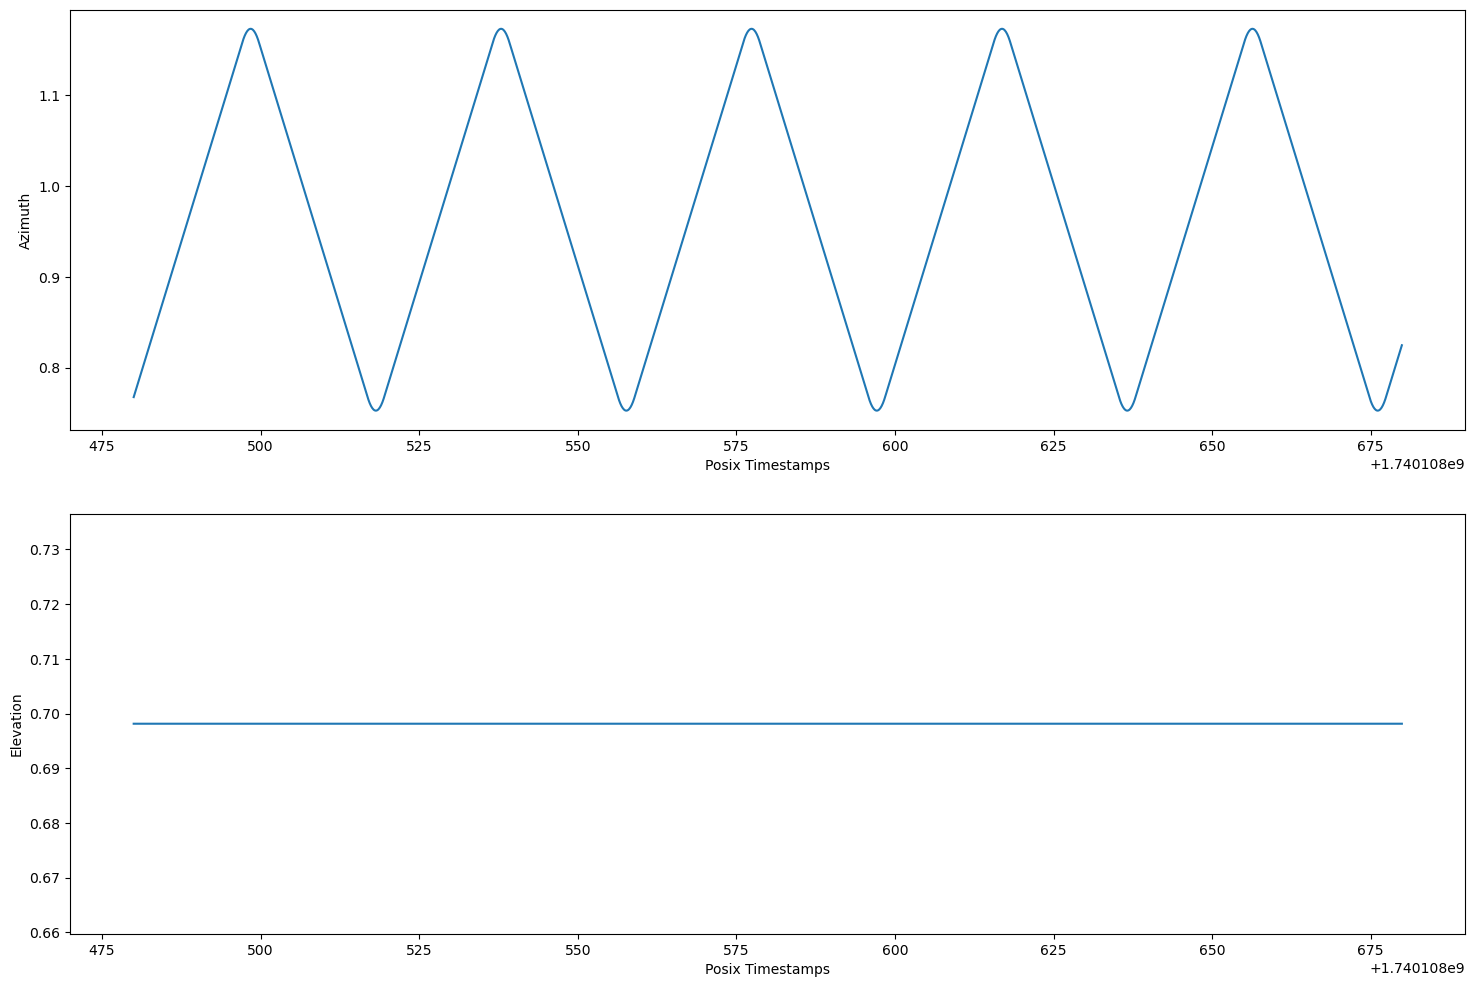

In [23]:
plot_scanning(data.obs[0], s_start=0, s_end=2000)

# Simulated Detector Data

Now we will simulate several components of our detector data.  Start with instrumental noise. 

## Instrumental Noise

We create a trivial noise model using nominal parameters from the focalplane table and then use this noise model to simulate timestreams.

In [24]:
nominal_noise = toast.ops.DefaultNoiseModel()
nominal_noise.apply(data)

In [25]:
sim_noise = toast.ops.SimNoise(
    noise_model=nominal_noise.noise_model,
)
sim_noise.apply(data)

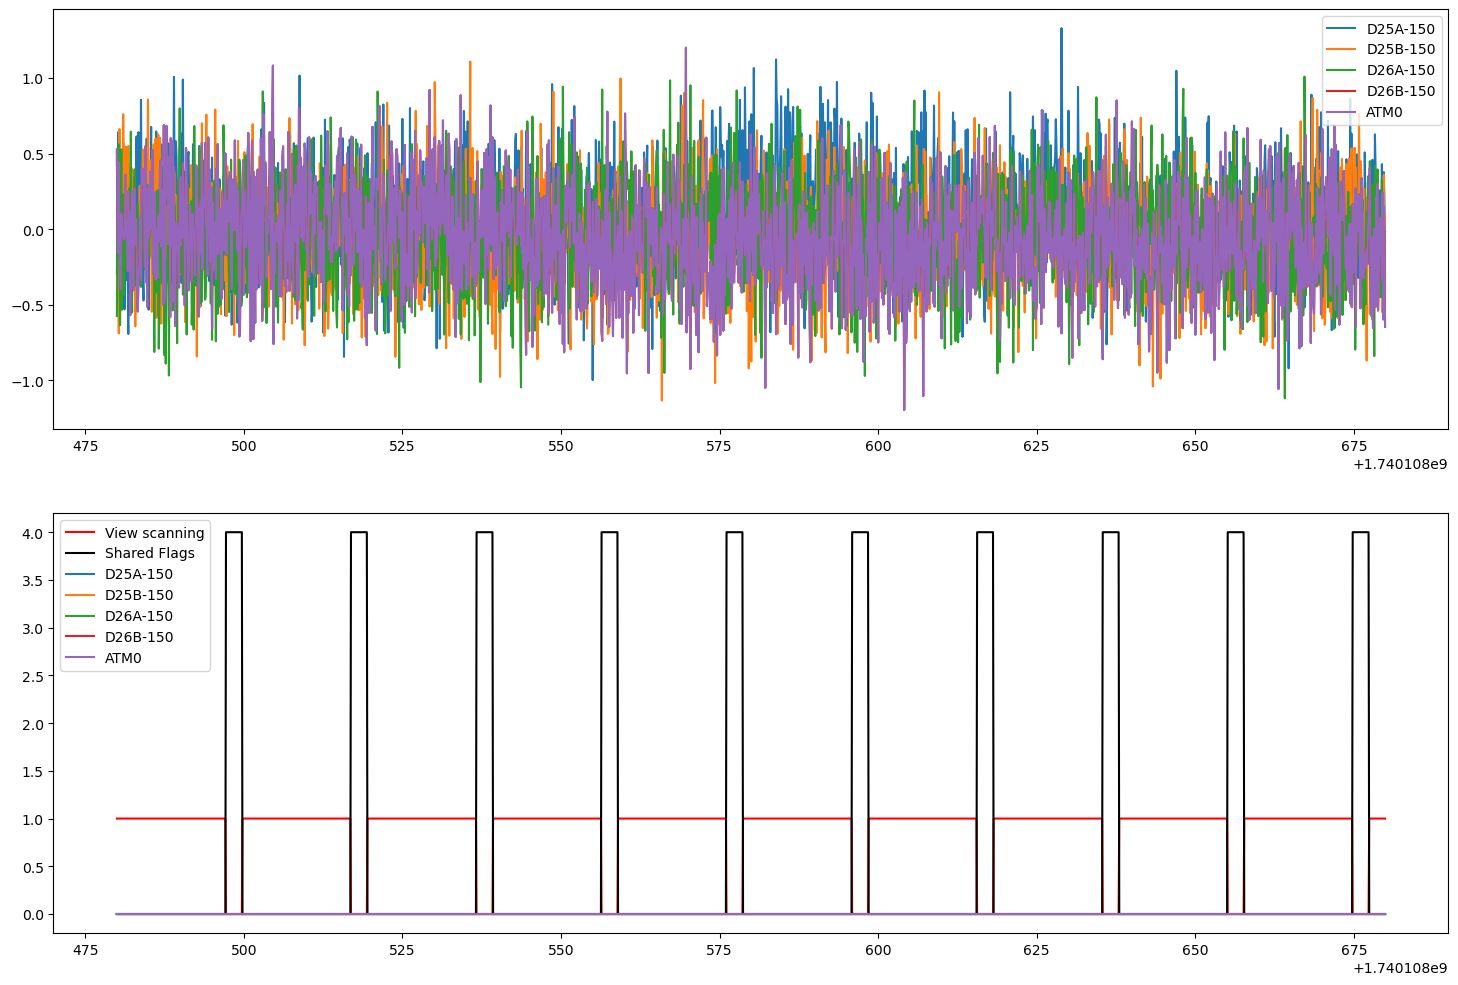

In [26]:
# Plot the last few detectors
plot_dets(data.obs[0], d_start=50, d_end=None, s_start=0, s_end=2000, view="scanning")

We can see that the "atmospheric monitor" detector does not look much different here, since we have only simulated detector noise.

## Simulated Atmosphere

Now we will simulate a 3D atmospheric slab moving in front of the telescope and integrate each detector along the line of site and over its bandpass.  In order to do this, we have to define an operator which knows how to compute detector pointing in Az/El coordinates.  This just uses the boresight pointing and the detector quaternion rotations from the boresight to compute detector pointing.

In [27]:
det_point_azel = toast.ops.PointingDetectorSimple(
    boresight=defaults.boresight_azel,
    quats="quats_azel"
)

In [28]:
sim_atm = toast.ops.SimAtmosphere(
    detector_pointing=det_point_azel,
    add_loading=True,
    lmin_center=0.001 * u.m,
    lmin_sigma=0.0001 * u.m,
    lmax_center=1 * u.m,
    lmax_sigma=0.1 * u.m,
    xstep=10 * u.m,
    ystep=10 * u.m,
    zstep=10 * u.m,
    zmax=200 * u.m,
    gain=4e-5,
    wind_dist=1000 * u.m,
)
sim_atm.apply(data)

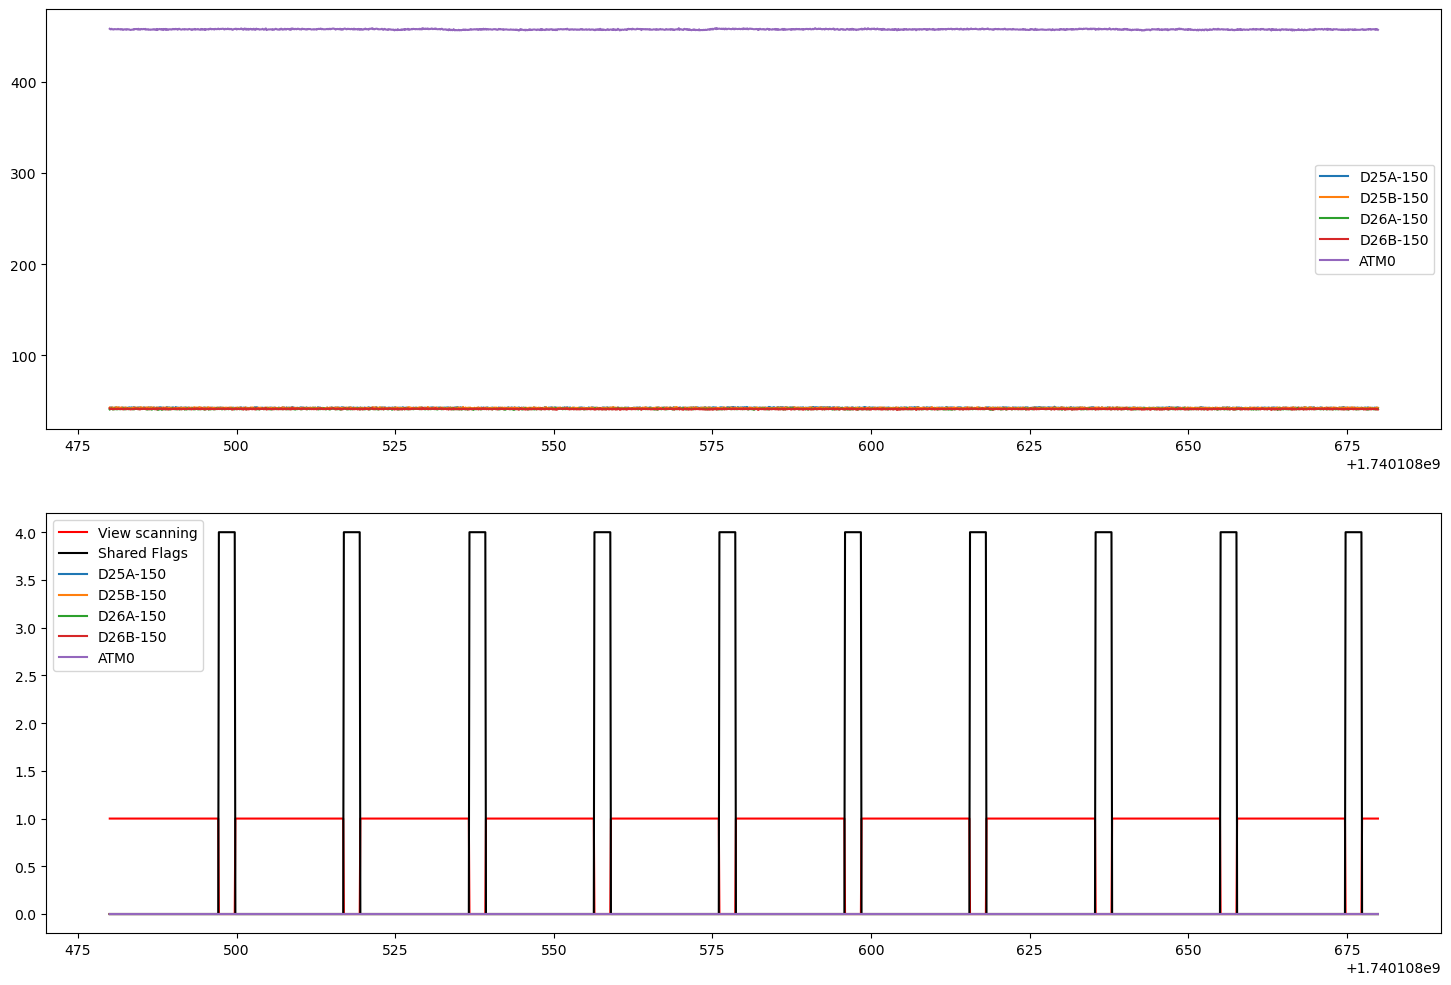

In [29]:
# Plot the last few detectors
plot_dets(data.obs[0], d_start=50, d_end=None, s_start=0, s_end=2000, view="scanning")

Here we see that the atmospheric monitor has substantially more power from the 183GHz water line.

# Map Making

First we want to flag the atmosphere monitor channel so that it is not considered "science" data for mapmaking purposes.

In [30]:
for ob in data.obs:
    ob.update_local_detector_flags({"ATM0": defaults.det_mask_processing})